In [1]:
## Advanced Lane Detection Pipeline

import cv2
from utils import cameraCaliberation
from utils.threshold import *
import matplotlib.pyplot as plt
%matplotlib inline

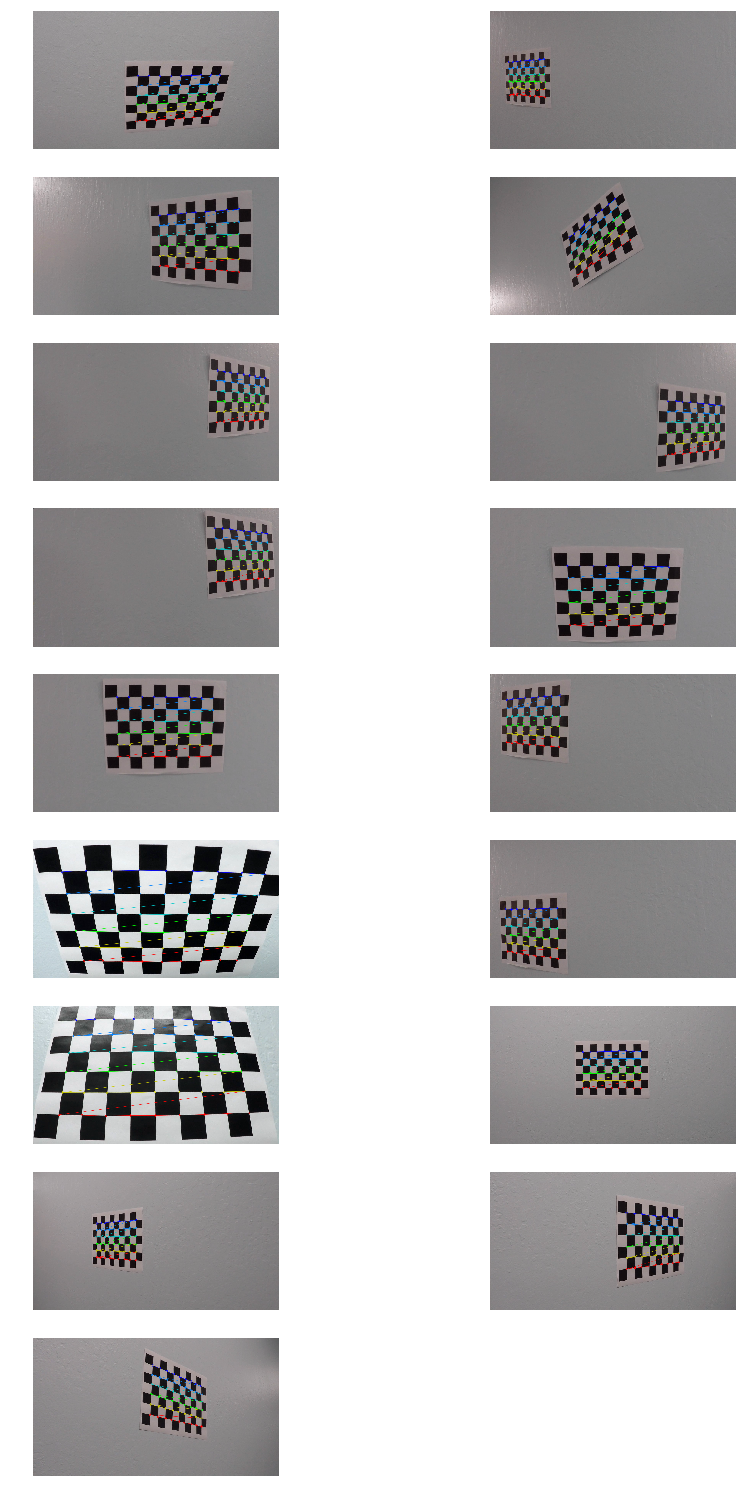

In [2]:
## Camera Caliberation
cal_path = 'camera_cal/calibration*.jpg'
(ret, mtx, dist, rvecs, tvecs), fig = cameraCaliberation.calc_caliberation_matrix(cal_path)

fig.set_size_inches(15,30)

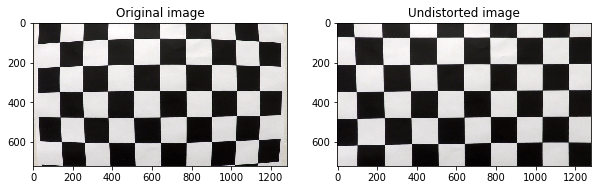

In [3]:
##TEST Undistort images

test_img = plt.imread("camera_cal/calibration1.jpg")
undist_img = cameraCaliberation.img_undistort(test_img, mtx, dist)

plt.figure(figsize=(10,30))
plt.subplot(1,2,1)
plt.imshow(test_img)
plt.title('Original image')

plt.subplot(1,2,2)
plt.imshow(undist_img)
plt.title('Undistorted image')


## Lane finding Pipeline

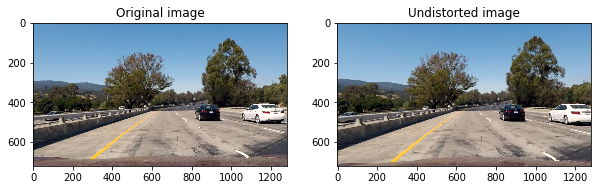

In [4]:
## 1. Testing distortion for first frame of video:

test_img = plt.imread("test_images/test1.jpg")
undist_img = cameraCaliberation.img_undistort(test_img, mtx, dist)

plt.figure(figsize=(10,30))
plt.subplot(1,2,1)
plt.imshow(test_img)
plt.title('Original image')

plt.subplot(1,2,2)
plt.imshow(undist_img)
plt.title('Undistorted image')

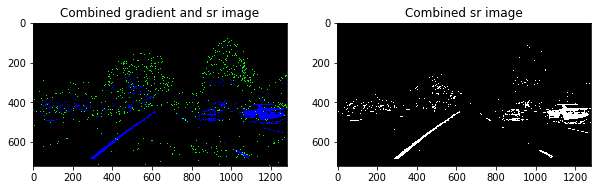

In [6]:
## 2. Thresholding for first frame of video

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
color_thresh = combine_thresh(test_img, color = True)
plt.imshow(color_thresh)
plt.title('Combined gradient and sr image')

plt.subplot(1,2,2)
sr_thresh = combine_thresh(test_img)
plt.imshow(sr_thresh, cmap='gray')
plt.title('Combined sr image')

In [7]:
img_size = [1280,720]
l_offset, r_offset = 250, 1000

# Define 4 source points src = np.float32([[,],[,],[,],[,]])
src = np.float32([[254,688],[598,450],[684,450],[1056,688]])
# Define 4 destination points dst = np.float32([[,],[,],[,],[,]])
#dst = np.float32([[250,720],[250,0],[1000,0],[1000,720])
dst = np.float32([[l_offset,img_size[1]],[l_offset,0],[r_offset,0],[r_offset,img_size[1]]])

def img_warped(img, src_points, dst_points):
    # Get the transform matrix, M
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    # Warp the image to top-down view
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    # Return the resulting image and matrix
    return warped, M

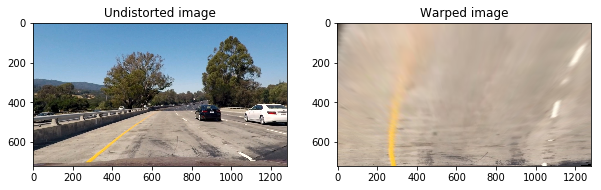

In [11]:
## 3. Perspective Transform and warping for first frame of video

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
plt.imshow(undist_img,  cmap='gray')
plt.title('Undistorted image')

plt.subplot(1,2,2)
warp_img, M = img_warped(undist_img, src_points = src, dst_points= dst)
plt.imshow(warp_img)
plt.title('Warped image')

In [13]:
## 4. Detect Lane Lines

class Line():
    def __init__(self, side):
        
        self.frame_count = 0
        self.side = side
        self.img = None
        #If the first frame or if needed in next frame
        self.use_hist = True
        #Polynomial coefficients for the line fit
        self.poly_fit = None
        
    def get_line_poly(self, binary_warped):
        
        self.frame_count +=1
        # Choose the number of sliding windows
        nwindows = 9
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        
        if self.use_hist == True:            
            # Take a histogram of the bottom half of the image
            histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            if self.side == 'right'
                x_base = np.argmax(histogram[midpoint:]) + midpoint
            else:
                x_base = np.argmax(histogram[:midpoint])
            
            # Set height of windows
            window_height = np.int(binary_warped.shape[0]/nwindows)
            # Current positions to be updated for each window
            x_current = x_base           
            # Create empty lists to receive left and right lane pixel indices
            lane_inds = []
        
            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_x_low = x_current - margin
                win_x_high = x_current + margin
                
                # Identify the nonzero pixels in x and y within the window
                good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0].nonzero()[0]
                # Append these indices to the lists
                lane_inds.append(good_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_inds) > minpix:
                    x_current = np.int(np.mean(nonzerox[good_inds]))
            
            # Concatenate the arrays of indices
            lane_inds = np.concatenate(lane_inds)
            if len(lane_inds) > minpix:
                #print('Min Pix found with histogram')
                
                # Extract left and right line pixel positions
                x = nonzerox[lane_inds]
                y = nonzeroy[lane_inds] 
                self.poly_fit = np.polyfit(y, x, 2)
                self.use_hist = False
                fitx = self.poly_fit[0]*ploty**2 + self.poly_fit[1]*ploty + self.poly_fit[2]
        
        # if not the first frame or no need to use hist
        else:
            lane_inds = ((nonzerox > (self.best_fit[0]*(nonzeroy**2) + self.best_fit[1]*nonzeroy + self.best_fit[2] - margin)) & (nonzerox < (self.best_fit[0]*(nonzeroy**2) + self.best_fit[1]*nonzeroy + self.best_fit[2] + margin))) 
            if len(lane_inds) > minpix:
                #print('Min Pix found with no histogram')
                # Extract left and right line pixel positions
                x = nonzerox[lane_inds]
                y = nonzeroy[lane_inds] 
                self.poly_fit = np.polyfit(y, x, 2)
                self.use_hist = False
                fitx = self.poly_fit[0]*ploty**2 + self.poly_fit[1]*ploty + self.poly_fit[2]

                

(720, 1280, 3)

In [26]:
x = np.ones((3,3))
x

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])

In [27]:
y = x.nonzero()
y

(array([0, 0, 0, 1, 1, 1, 2, 2, 2]), array([0, 1, 2, 0, 1, 2, 0, 1, 2]))

In [29]:
# whos

In [ ]:
## 5. Detect Lane Curvature